In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
from clean_names import clean_names, clean_opponent_names

In [2]:
df = pd.read_csv('data/master_df.csv')

team_list = pd.read_json('data/master_team_list.json', orient='values')
team_list = team_list[0]

df = df[~df['opponent'].isna()]
df['opponent'] = clean_opponent_names(df['opponent'])
df = df[df['opponent'].isin(team_list)]

In [5]:
df['result'] = np.where(df['points_team'] > df['points_opponent'], 'W', 'L')
records = (
    df.groupby('team')['result']
      .value_counts()
      .unstack(fill_value=0)
)
df = df.merge(records, on = 'team')

In [6]:
# Encode categorical variables as indices
teams = df['team'].unique()
team_idx = df['team'].apply(lambda x: np.where(teams == x)[0][0])
opponents = df['opponent'].unique()
opp_idx = df['opponent'].apply(lambda x: np.where(opponents == x)[0][0])

conditions = [
    df['home'] == True,
    df['away'] == True,
    df['neutral'] == True
]

choices = [1, -1, 0]

df['location'] = np.select(conditions, choices, default=0)

In [7]:
with pm.Model() as model:
    
    # League average PPP
    mu = pm.Normal('mu', mu=1, sigma=0.5)
    
    # Team random effects (offense)
    sigma_team = pm.HalfNormal('sigma_team', sigma=1.0)
    team_off_raw = pm.Normal('team_off_raw', mu=0, sigma=1, shape=len(teams))
    team_off = pm.Deterministic('team_off', sigma_team * (team_off_raw))
    
    # Opponent random effects (defense)
    sigma_opp = pm.HalfNormal('sigma_opp', sigma=1.0)
    opp_def_raw = pm.Normal('opp_def_raw', mu=0, sigma=1, shape=len(opponents))
    opp_def = pm.Deterministic('opp_def', sigma_opp * (opp_def_raw))
    
    # Home-court effect
    beta_home = pm.Normal('beta_home', mu=0, sigma=0.02)
    
    # Expected PPP for each game
    ppp_hat = (
        mu
        + team_off[team_idx]             # offense of team
        - opp_def[opp_idx]               # defense of opponent
        + beta_home * df['location']         # home-court
    )
    
    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=0.1)
    y = pm.Normal('y', mu=ppp_hat, sigma=sigma, observed=df['ppp_off_team'])
    
    # Sample posterior
    trace = pm.sample(1000, tune=500, target_accept=0.9, progressbar=True)

# Examine results
az.summary(trace, var_names=["mu", "team_off", "opp_def", "beta_home"])


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_team, team_off_raw, sigma_opp, opp_def_raw, beta_home, sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.075,0.006,1.065,1.086,0.000,0.000,466.0,1090.0,1.01
team_off[0],-0.062,0.031,-0.124,-0.008,0.001,0.001,3015.0,2725.0,1.00
team_off[1],-0.122,0.029,-0.177,-0.071,0.000,0.000,3609.0,2863.0,1.00
team_off[2],0.118,0.029,0.065,0.173,0.000,0.000,3527.0,2871.0,1.00
team_off[3],0.147,0.028,0.093,0.198,0.000,0.000,3533.0,3242.0,1.00
...,...,...,...,...,...,...,...,...,...
opp_def[361],0.053,0.029,0.000,0.108,0.000,0.000,4033.0,3046.0,1.00
opp_def[362],0.024,0.029,-0.029,0.078,0.000,0.000,3922.0,2456.0,1.00
opp_def[363],0.002,0.029,-0.054,0.057,0.000,0.000,4030.0,2844.0,1.00
opp_def[364],-0.019,0.028,-0.072,0.035,0.000,0.000,3846.0,2934.0,1.00


In [8]:
teams = df['team'].unique()

In [9]:
team_idx_map = {team: i for i, team in enumerate(teams)}
team_name = "virginia-tech"  # example

# Posterior samples for team offense
off_samples = trace.posterior['team_off'].sel(team_off_dim_0=team_idx_map[team_name])

# Posterior mean (expected rating)
off_mean = off_samples.mean().item()

# Adjusted offensive efficiency (points per possession)
mu_mean = trace.posterior['mu'].mean().item()
adj_off_eff = (mu_mean + off_mean)

print(f"{team_name} adjusted offensive efficiency: {adj_off_eff:.2f} points per possession")


virginia-tech adjusted offensive efficiency: 1.13 points per possession


In [10]:
# Suppose opponents are listed in 'Opponent' variable
opponents = df['opponent'].unique()
opp_idx_map = {opp: i for i, opp in enumerate(opponents)}

opp_name = "virginia"  # example
def_samples = trace.posterior['opp_def'].sel(opp_def_dim_0=opp_idx_map[opp_name])

def_mean = def_samples.mean().item()
adj_def_eff = (mu_mean - def_mean)

print(f"{opp_name} adjusted defensive efficiency: {adj_def_eff:.2f} points per possession")

virginia adjusted defensive efficiency: 0.99 points per possession


In [13]:
adj_off_eff = {}
for team, i in team_idx_map.items():
    off_samples = trace.posterior['team_off'].sel(team_off_dim_0=i)
    adj_off_eff[team] = (trace.posterior['mu'].mean().item() + off_samples.mean().item())

adj_def_eff = {}
for opp, i in opp_idx_map.items():
    def_samples = trace.posterior['opp_def'].sel(opp_def_dim_0=i)
    adj_def_eff[opp] = (trace.posterior['mu'].mean().item() - def_samples.mean().item())

off_df = pd.DataFrame({
    'Team': list(adj_off_eff.keys()),
    'AdjOffEff': list(adj_off_eff.values())
})

def_df = pd.DataFrame({
    'Team': list(adj_def_eff.keys()),
    'AdjDefEff': list(adj_def_eff.values())
})

rankings = off_df.merge(def_df, on="Team", how="left")
rankings = rankings.merge(records, left_on='Team', right_on='team')

rankings['Total'] = rankings['AdjOffEff'] - rankings['AdjDefEff']
rankings = rankings.sort_values('Total', ascending=False)
rankings['Rank'] = range(1, len(rankings) + 1)

print(rankings)

# Making the data table pretty
rankings['Team'] = rankings['Team'].str.upper()
rankings['Team'] = rankings['Team'].str.replace('-', ' ')
rankings = rankings[['Rank', 'Team', 'W', 'L', 'AdjOffEff', 'AdjDefEff', 'Total']]

rankings.to_csv('data/current_rankings.csv', index = False)

                         Team  AdjOffEff  AdjDefEff   L   W     Total  Rank
73                       duke   1.237947   0.909767   1  19  0.328180     1
175                  michigan   1.223915   0.899595   1  20  0.324320     2
10                    arizona   1.233099   0.913694   0  21  0.319405     3
103                   gonzaga   1.201750   0.922785   1  21  0.278966     4
118                  illinois   1.258094   0.993014   3  18  0.265080     5
..                        ...        ...        ...  ..  ..       ...   ...
189              morgan-state   0.965939   1.189105  13   5 -0.223166   361
274      south-carolina-state   0.948865   1.187341  16   3 -0.238475   362
95               gardner-webb   0.936859   1.205842  19   1 -0.268983   363
60               coppin-state   0.927144   1.221609  19   2 -0.294465   364
182  mississippi-valley-state   0.884688   1.204564  20   0 -0.319876   365

[365 rows x 7 columns]


In [18]:
# Group by team and compute average possessions
team_avg_possessions = df.groupby('team')['possession_team'].mean().reset_index()

# Rename the column for clarity
team_avg_possessions.rename(columns={'possessions': 'avg_possessions'}, inplace=True)

print(team_avg_possessions)


                  team  possession_team
0    abilene-christian        67.022857
1            air-force        65.920000
2                akron        73.093333
3              alabama        77.440000
4           alabama-am        68.702857
..                 ...              ...
360       wright-state        70.630000
361            wyoming        74.155556
362             xavier        72.672000
363               yale        66.333333
364   youngstown-state        69.666667

[365 rows x 2 columns]


In [12]:
from scipy.stats import norm
import numpy as np

def predict_win_prob(team, opponent, trace, team_idx_map, opp_idx_map, 
                     venue=0, team_possessions=70, opp_possessions=70):
    """
    Predict win probability between two teams, accounting for different possessions.

    Parameters:
    -----------
    team : str
        Name of the team whose win probability we are predicting.
    opponent : str
        Name of the opponent team.
    trace : pm.backends.base.MultiTrace
        Posterior samples from PyMC model.
    team_idx_map : dict
        Mapping from team names to indices in 'team_offense'.
    opp_idx_map : dict
        Mapping from team names to indices in 'opp_defense'.
    venue : int
        1 if 'team' is at home, 0 if neutral, -1 if away.
    team_possessions : float
        Expected number of possessions for the team.
    opp_possessions : float
        Expected number of possessions for the opponent.

    Returns:
    --------
    float
        Win probability for 'team'.
    """

    # Indices
    i = team_idx_map[team]
    j = opp_idx_map[opponent]

    # Encode venue
    is_home = 1 if venue == 1 else 0
    is_away = 1 if venue == -1 else 0

    # Average posterior estimates
    mu = trace.posterior["mu"].mean().item()
    team_off = trace.posterior["team_off"].sel(team_off_dim_0=i).mean().item()
    opp_off = trace.posterior["team_off"].sel(team_off_dim_0=j).mean().item()
    team_def = trace.posterior["opp_def"].sel(opp_def_dim_0=i).mean().item()
    opp_def = trace.posterior["opp_def"].sel(opp_def_dim_0=j).mean().item()
    beta_home = trace.posterior["beta_home"].mean().item()

    # Expected PPP for each team
    team_ppp = mu + team_off - opp_def + beta_home * is_home
    opp_ppp  = mu + opp_off - team_def + beta_home * is_away

    # Convert PPP to expected points using team-specific possessions
    team_points = team_ppp * team_possessions
    opp_points  = opp_ppp * opp_possessions

    margin = team_points - opp_points

    print(f"{team} expected points: {team_points:.1f}")
    print(f"{opponent} expected points: {opp_points:.1f}")
    print(f"Expected margin: {margin:.1f}")

    # Margin and probability
    sigma_points = 12  # std dev of points per game
    win_prob = norm.cdf(margin / sigma_points)

    return win_prob

# Example usage
win_prob = predict_win_prob(
    "virginia-tech", 
    "maryland-eastern-shore", 
    trace, 
    team_idx_map, 
    opp_idx_map, 
    venue=1, 
    team_possessions=70, 
    opp_possessions=70
)
print(f"Virginia-Tech home win probability: {win_prob:.2%}")


virginia-tech expected points: 81.8
maryland-eastern-shore expected points: 79.5
Expected margin: 2.3
Virginia-Tech home win probability: 57.61%


In [55]:
trace.posterior['team_off'].min(), trace.posterior['team_off'].max()
trace.posterior['opp_def'].min(), trace.posterior['opp_def'].max()


(<xarray.DataArray 'opp_def' ()> Size: 8B
 array(-0.26602332),
 <xarray.DataArray 'opp_def' ()> Size: 8B
 array(0.28186286))

In [41]:
import arviz as az

# Summary of key variables
summary = az.summary(trace, var_names=['mu', 'team_off', 'opp_def', 'beta_home'])
print(summary)


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu            1.063  0.002   1.059    1.068      0.000    0.000    5012.0   
team_off[0]  -0.051  0.043  -0.131    0.032      0.001    0.001    3688.0   
team_off[1]  -0.066  0.036  -0.136   -0.000      0.001    0.001    3663.0   
team_off[2]   0.143  0.039   0.072    0.218      0.001    0.001    3239.0   
team_off[3]   0.138  0.040   0.067    0.218      0.001    0.001    3578.0   
...             ...    ...     ...      ...        ...      ...       ...   
opp_def[361] -0.012  0.043  -0.097    0.067      0.001    0.001    3812.0   
opp_def[362] -0.024  0.042  -0.105    0.053      0.001    0.001    4205.0   
opp_def[363]  0.003  0.039  -0.071    0.076      0.001    0.001    4411.0   
opp_def[364] -0.034  0.039  -0.106    0.039      0.001    0.001    3638.0   
beta_home     0.049  0.003   0.043    0.055      0.000    0.000    1663.0   

              ess_tail  r_hat  
mu              3134.0    1.0  
team_off[0]

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'team_off'}>,
        <Axes: title={'center': 'team_off'}>],
       [<Axes: title={'center': 'opp_def'}>,
        <Axes: title={'center': 'opp_def'}>],
       [<Axes: title={'center': 'beta_home'}>,
        <Axes: title={'center': 'beta_home'}>]], dtype=object)

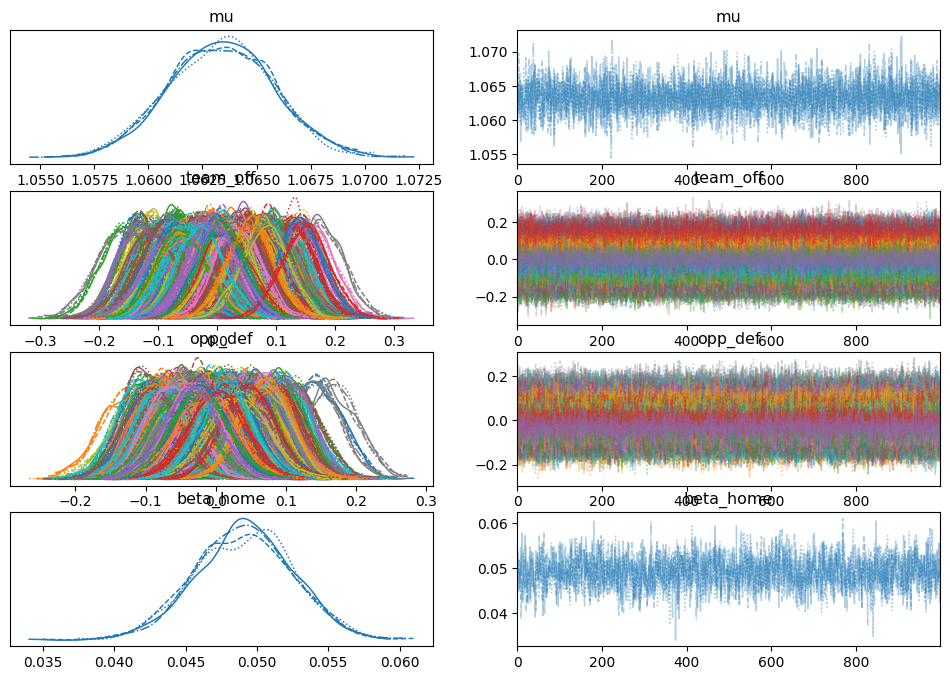

In [42]:
az.plot_trace(trace, var_names=['mu', 'team_off', 'opp_def', 'beta_home'])


array([<Axes: title={'center': 'mu'}>,
       <Axes: title={'center': 'beta_home'}>], dtype=object)

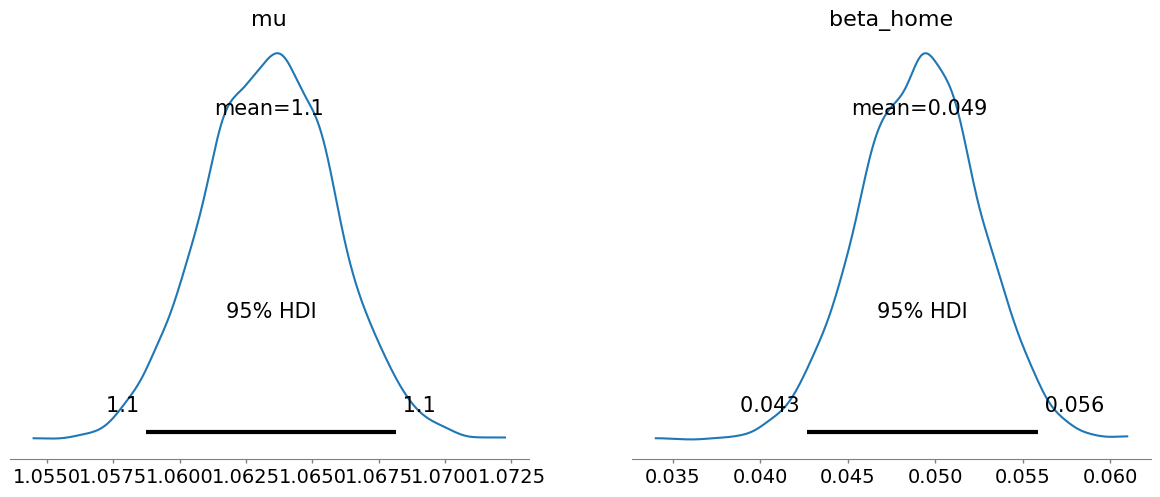

In [43]:
az.plot_posterior(trace, var_names=['mu', 'beta_home'], hdi_prob=0.95)


c:\Users\rpwju\AppData\Local\Programs\Python\Python313\Lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='team_off\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='team_off\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='team_off\n3'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='team_off\n4'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='team_off\n5'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='team_off\n6'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='team_off\n7'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='team_off\n0', ylabel='team_off\n8'>,
        <Axes: xlabel='team_off\n1'>, <Axes: xlabel='team_off\n2'>,
        <Axes: xlabel='team_off\n3'>, <Axes: xlabel='

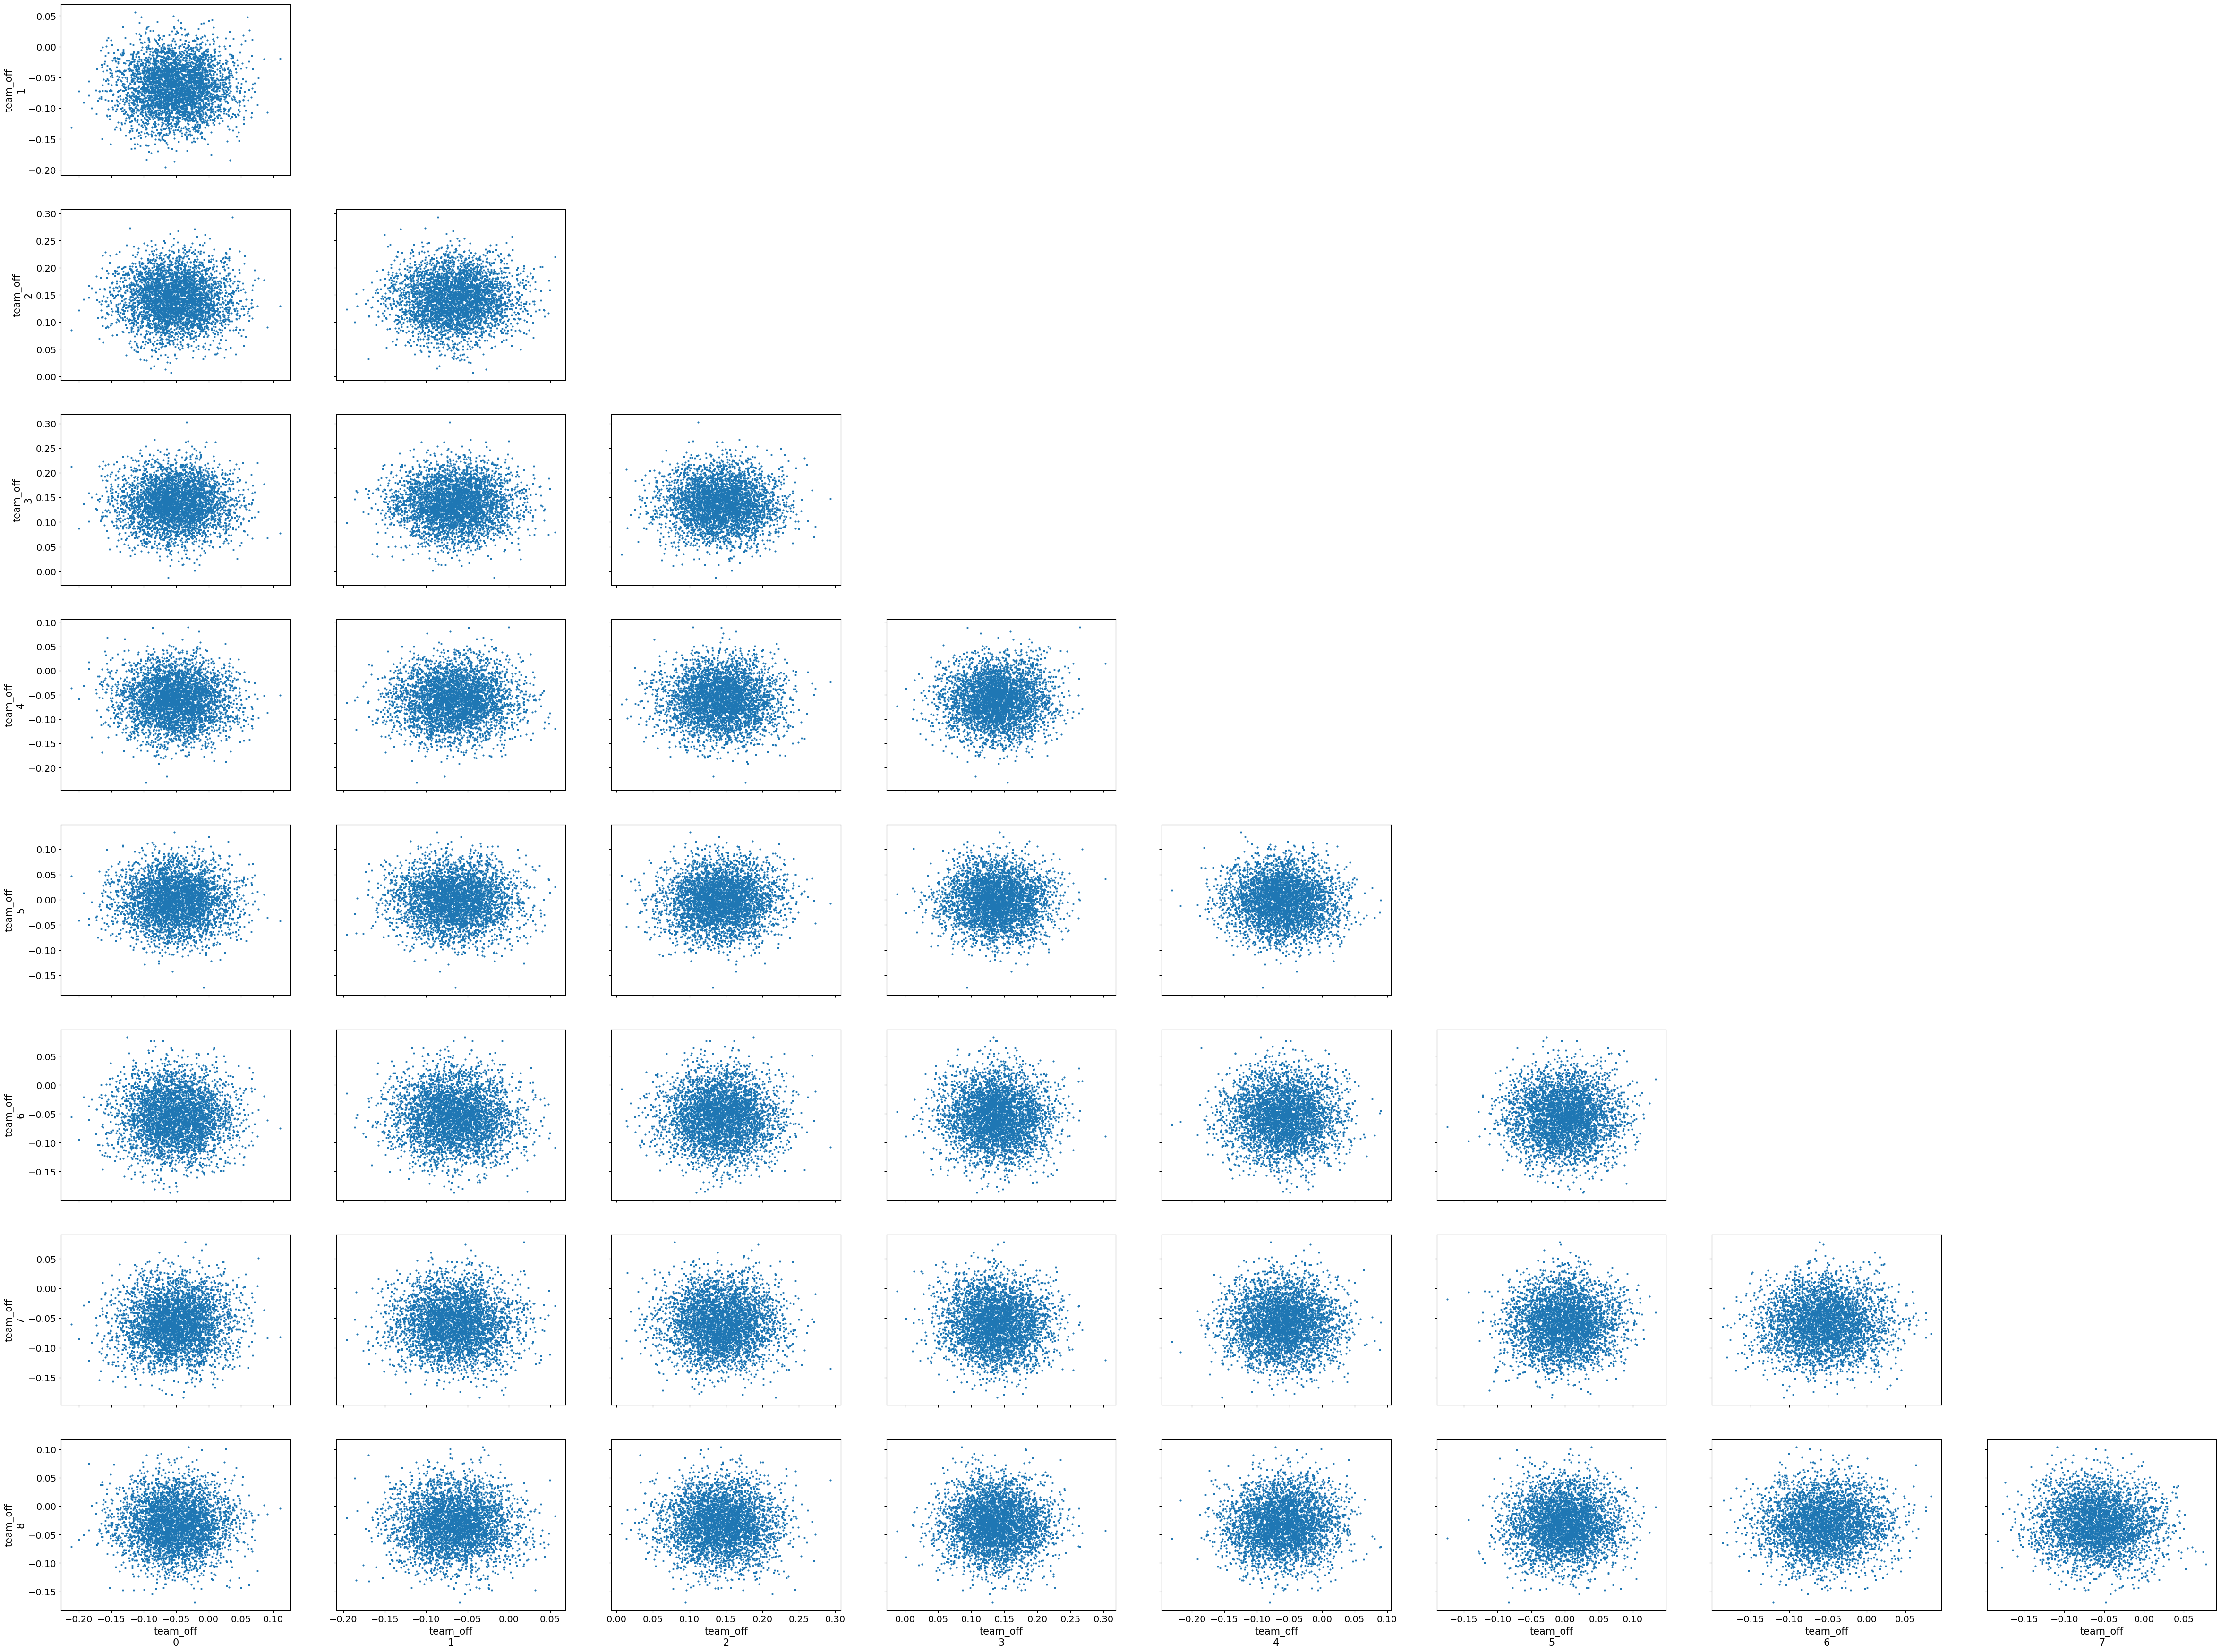

In [44]:
az.plot_pair(trace, var_names=['team_off', 'opp_def'], kind='scatter')


In [49]:
teams = ["virginia-tech", "coppin-state"]
for team in teams:
    off_mean = trace.posterior['team_off'].sel(team_off_dim_0=team_idx_map[team]).mean().item()
    def_mean = trace.posterior['opp_def'].sel(opp_def_dim_0=team_idx_map[team]).mean().item()
    print(f"{team} offense: {off_mean:.3f}, defense: {def_mean:.3f}")


virginia-tech offense: 0.047, defense: 0.003
coppin-state offense: -0.132, defense: 0.101
